In [174]:
import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib

# Case investegation with mobile data

In [3]:
mob_data = pd.read_csv("../datasets/joined_mobdata.zip", compression='zip')
mob_data.tid = pd.to_datetime(mob_data.tid)
mob_data.index = mob_data.tid

mob_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 678613 entries, 2018-01-01 00:22:00 to 2021-12-31 23:43:00
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0             678613 non-null  int64         
 1   tid                    678613 non-null  datetime64[ns]
 2   hastighet_ned          678613 non-null  float64       
 3   hastighet_opp          678613 non-null  float64       
 4   lengdegrad             678613 non-null  float64       
 5   breddegrad             678613 non-null  float64       
 6   klient_type            678613 non-null  object        
 7   teknologi              678047 non-null  object        
 8   ip_as_name             675039 non-null  object        
 9   nettverkstype          678613 non-null  int64         
 10  landkode               675056 non-null  object        
 11  land_geoip             678613 non-null  object        
 12  tilbyder  

## Telia case


4. oktober 2021 på kvelden (rundt kl 2000) begynte Telia kunder å miste nettet. Dette var også samtidig som Facebook var nede grunnet DNS/BGP problemer. Telia problemet berørte kunder over hele landet og var derfor ikke geografisk avgrenset. 

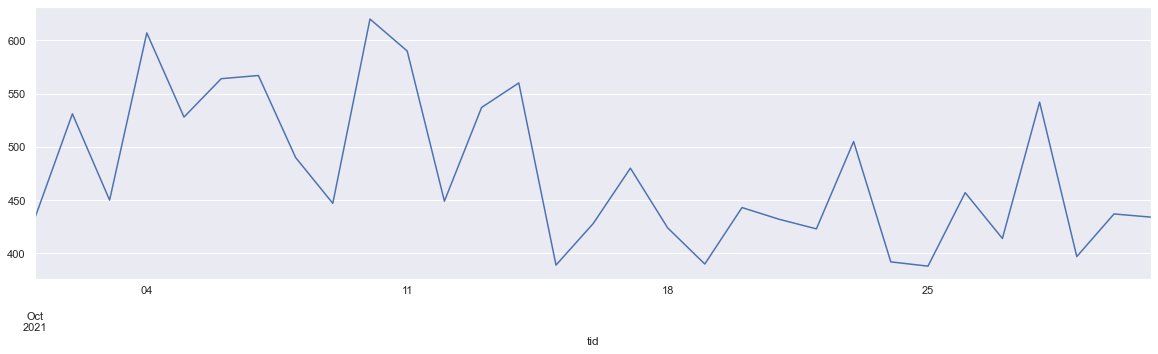

In [53]:
# ser på antall tester i tidsrommet
import seaborn as sns
sns.set_theme()
oktober_df = mob_data.loc["2021-10"]
count_okt = oktober_df['hastighet_ned'].resample("D").count()
ax = count_okt.plot(figsize=(20,5))
ax.grid(True, axis="both")



Ser det er en liten topp 4. oktober i antall målinger, men omtrent like mange målinger 10. okt og 11. okt.
ser på latency og up/down speeds

In [25]:
median_metrics_okt = oktober_df[['hastighet_ned', 'hastighet_opp', 'ping_median']].resample("D").median()
avg_metrics_okt = oktober_df[['hastighet_ned', 'hastighet_opp', 'ping_median']].resample("D").mean()

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

In [44]:
sb_df = pd.melt(median_metrics_okt, ignore_index=False).reset_index()

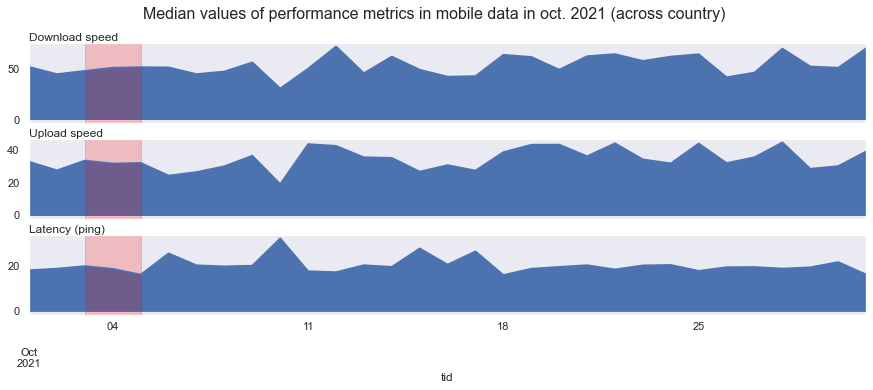

In [74]:
import seaborn as sns
sns.set_theme(style="dark")
fig, axs = plt.subplots(nrows=3, figsize=(15,5), sharex=True)
fig.suptitle('Median values of performance metrics in mobile data in oct. 2021 (across country)', fontsize=16)
median_metrics_okt['hastighet_ned'].plot(ax=axs[0], kind="area")
median_metrics_okt['hastighet_opp'].plot(ax=axs[1], kind="area")
median_metrics_okt['ping_median'].plot(ax=axs[2], kind="area")
titles = ["Download speed", "Upload speed", "Latency (ping)"]
for i, ax in enumerate(axs):
    ax.axvspan(np.datetime64('2021-10-03'), np.datetime64('2021-10-05'), color='red', alpha=0.2, clip_on=False)
    ax.set_title(titles[i], loc='left', pad =2)
plt.show()



Ikke noe spsielt i performance metrics for den dagen

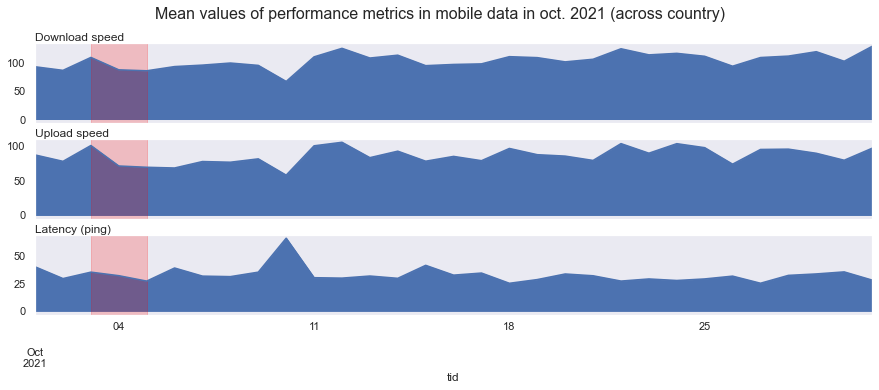

In [77]:
fig, axs = plt.subplots(nrows=3, figsize=(15,5), sharex=True)
fig.suptitle('Mean values of performance metrics in mobile data in oct. 2021 (across country)', fontsize=16)
avg_metrics_okt['hastighet_ned'].plot(ax=axs[0], kind="area")
avg_metrics_okt['hastighet_opp'].plot(ax=axs[1], kind="area")
avg_metrics_okt['ping_median'].plot(ax=axs[2], kind="area")
titles = ["Download speed", "Upload speed", "Latency (ping)"]
for i, ax in enumerate(axs):
    ax.axvspan(np.datetime64('2021-10-03'), np.datetime64('2021-10-05'), color='red', alpha=0.2, clip_on=True)
    ax.set_title(titles[i], loc='left', pad =2)
plt.show()


Ser på public AS name

In [94]:
top_ip_as= oktober_df['public_ip_as_name'].value_counts().head().index
oktober_df['public_ip_as_name'].value_counts().head(10)

TELENOR-NEXTEL Telenor Norge AS, NO               5873
ALTIBOX_AS Norway, NO                             2393
ASN-CATCHCOM, NO                                  1343
GET-NO GET Norway, NO                             1199
NETCOM-AS Oslo, Norway, NO                         959
NEXTGENTEL NEXTGENTEL Autonomous System, NO        506
NTE-BREDBAND NIX 1, Oslo, Norway, NO               395
TELIA-NORWAY-AS Telia Norway Core Networks, NO     326
EIDSIVA-ASN, NO                                    270
AS-DIRECTCONNECT, NO                               178
Name: public_ip_as_name, dtype: int64

In [106]:
as_names = pd.Series(top_ip_as).append(pd.Series('TELIA-NORWAY-AS Telia Norway Core Networks, NO', index=[5,]))
as_names

0               TELENOR-NEXTEL Telenor Norge AS, NO
1                             ALTIBOX_AS Norway, NO
2                                  ASN-CATCHCOM, NO
3                             GET-NO GET Norway, NO
4                        NETCOM-AS Oslo, Norway, NO
5    TELIA-NORWAY-AS Telia Norway Core Networks, NO
dtype: object

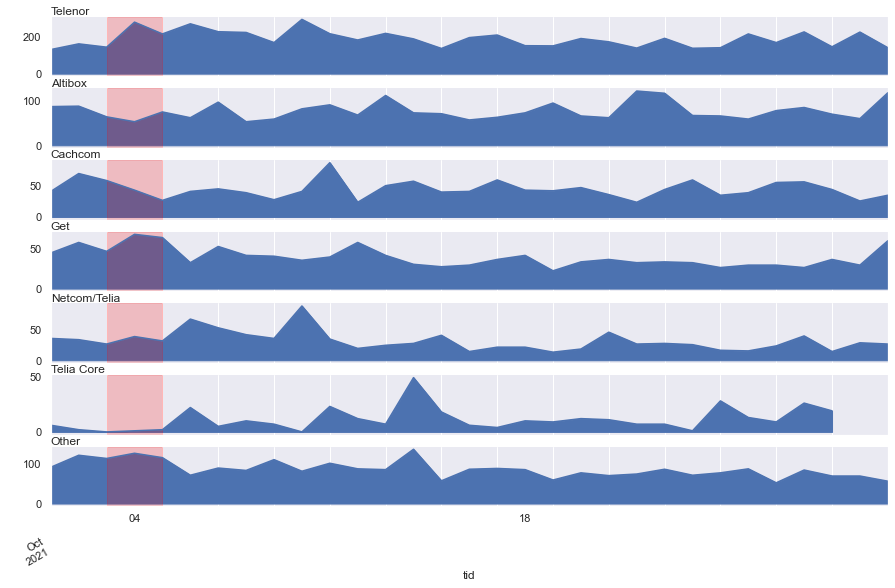

In [113]:
fig, axes = plt.subplots(nrows=7, sharex=True, figsize=(15,10))

for i in range(6):
    aggr = oktober_df[oktober_df['public_ip_as_name']== as_names[i]]
    aggr = aggr['hastighet_ned'].resample('D').count()
    aggr.plot(ax=axes[i], kind='area')
#Plot all other ISPs
other = oktober_df[~oktober_df['public_ip_as_name'].isin(as_names)]
aggr = other['hastighet_ned'].resample('D').count()
aggr.plot(ax=axes[6], kind='area')

major_ticks = np.arange('2021-10', '2021-11',2, dtype='datetime64[D]')
titles=["Telenor", "Altibox", "Cachcom", "Get", "Netcom/Telia", "Telia Core" ,"Other"]
for i, ax in enumerate(axes):
    ax.spines['top'].set_visible(False)
    ax.set_title(titles[i], loc='left', pad =2)
    ax.set_xticks(major_ticks)
    ax.grid(axis='x')
    ax.axvspan(np.datetime64('2021-10-03'), np.datetime64('2021-10-05'), color='red', alpha=0.2, clip_on=True)

plt.gcf().autofmt_xdate()    
plt.show()

Ingen spike i Telia sine IP adresse (registrert på AS) 

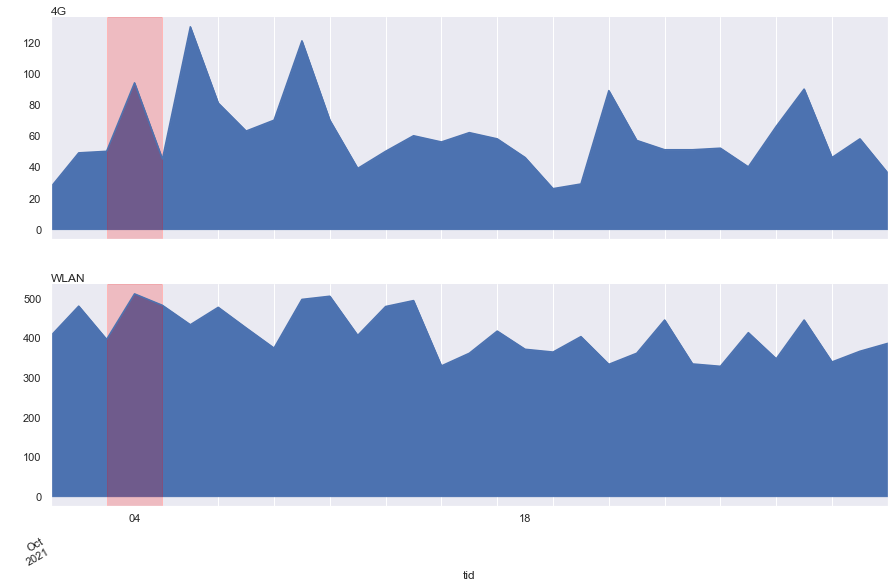

In [120]:
#Look at teknology
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,10))
tek=['4G', 'WLAN']
for i in range(2):
    aggr = oktober_df[oktober_df['teknologi']== tek[i]]
    aggr = aggr['hastighet_ned'].resample('D').count()
    aggr.plot(ax=axes[i], kind='area')

major_ticks = np.arange('2021-10', '2021-11',2, dtype='datetime64[D]')
for i, ax in enumerate(axes):
    ax.spines['top'].set_visible(False)
    ax.set_title(tek[i], loc='left', pad =2)
    ax.set_xticks(major_ticks)
    ax.grid(axis='x')
    ax.axvspan(np.datetime64('2021-10-03'), np.datetime64('2021-10-05'), color='red', alpha=0.2, clip_on=True)

plt.gcf().autofmt_xdate()    
plt.show()

No abnormal behavior shown

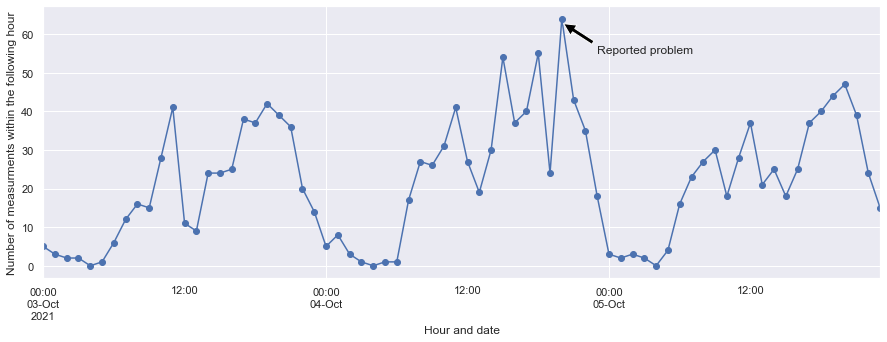

In [158]:
#look at hourly behaviour
ax = oktober_df.loc['2021-10-03':'2021-10-05']['hastighet_ned'].resample("H").count().plot(figsize=(15,5), style="-o", grid=True)
plt.ylabel("Number of measurments within the following hour")
plt.xlabel("Hour and date")
ax.annotate('Reported problem', 
            xy=(np.datetime64('2021-10-04 20:00:00'), 63), 
            xytext=(np.datetime64('2021-10-04 23:00:00'), 55), 
            arrowprops=dict(facecolor='black', shrink=0.05),)
#ax.axvspan(np.datetime64('2021-10-04 15:30:00'), np.datetime64('2021-10-04 22:30:00'), color='red', alpha=0.1, clip_on=True)


plt.show()

Kan se en peak i målinger kl 20:00 og den påfølgende timen. Avtarfort utover kvelden.

In [155]:
eight = oktober_df.loc['2021-10-04 20:00:00':'2021-10-04 21:00:00']
eight["ip_as_name"].value_counts()

TELENOR-NEXTEL Telenor Norge AS, NO                     41
GET-NO GET Norway, NO                                   10
ALTIBOX_AS Norway, NO                                    9
NETCOM-AS Oslo, Norway, NO                               2
SOGNENETT-AS Providing fiber and wireless access, NO     1
ASN-CATCHCOM, NO                                         1
Name: ip_as_name, dtype: int64

In [156]:
eight["navn"].value_counts()

Senja            7
Hole             6
Oslo             5
Bergen           4
Hitra            3
Træna            2
Verdal           2
Bærum            2
Indre Østfold    2
Steinkjer        2
Øyer             2
Hå               2
Lillestrøm       2
Stange           2
Vik              1
Fredrikstad      1
Orkland          1
Sør-Odal         1
Moss             1
Åsnes            1
Drammen          1
Råde             1
Etne             1
Tinn             1
Lillesand        1
Stjørdal         1
Grimstad         1
Kristiansand     1
Birkenes         1
Flakstad         1
Nome             1
Smøla            1
Ringsaker        1
Froland          1
Tønsberg         1
Name: navn, dtype: int64

## Case 2: Telia østfold 7. okt 

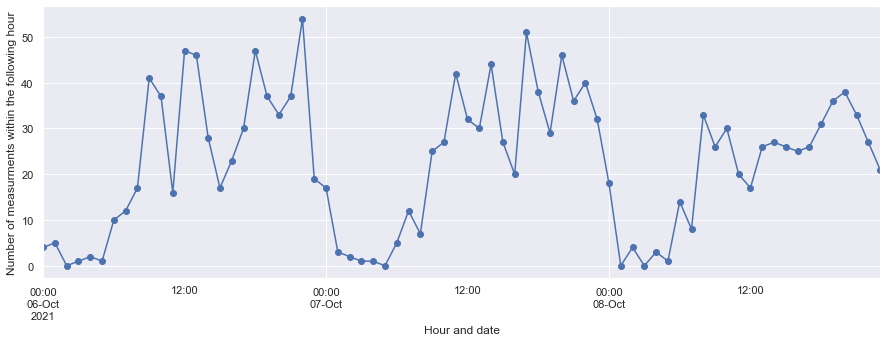

In [159]:
#look at hourly behaviour
ax = oktober_df.loc['2021-10-06':'2021-10-08']['hastighet_ned'].resample("H").count().plot(figsize=(15,5), style="-o", grid=True)
plt.ylabel("Number of measurments within the following hour")
plt.xlabel("Hour and date")
ax.annotate('Reported problem', 
            xy=(np.datetime64('2021-10-07 20:00:00'), 63), 
            xytext=(np.datetime64('2021-10-07 23:00:00'), 55), 
            arrowprops=dict(facecolor='black', shrink=0.05),)
#ax.axvspan(np.datetime64('2021-10-04 15:30:00'), np.datetime64('2021-10-04 22:30:00'), color='red', alpha=0.1, clip_on=True)


plt.show()

In [160]:
kveld_sujende = oktober_df.loc['2021-10-07 17:00:00':'2021-10-04 23:00:00']
eight["navn"].value_counts()

Senja            7
Hole             6
Oslo             5
Bergen           4
Hitra            3
Træna            2
Verdal           2
Bærum            2
Indre Østfold    2
Steinkjer        2
Øyer             2
Hå               2
Lillestrøm       2
Stange           2
Vik              1
Fredrikstad      1
Orkland          1
Sør-Odal         1
Moss             1
Åsnes            1
Drammen          1
Råde             1
Etne             1
Tinn             1
Lillesand        1
Stjørdal         1
Grimstad         1
Kristiansand     1
Birkenes         1
Flakstad         1
Nome             1
Smøla            1
Ringsaker        1
Froland          1
Tønsberg         1
Name: navn, dtype: int64

In [161]:
kommuner_østfold=[ "Halden","Moss", "Sarpsborg", "Fredrikstad", "Hvaler", "Aremark", "Marker", "Indre Østfold" ,"Skiptvet", "Rakkestad", "Råde", "Våler"]

In [162]:
oktober_østfold = oktober_df[oktober_df.navn.isin(kommuner_østfold)]

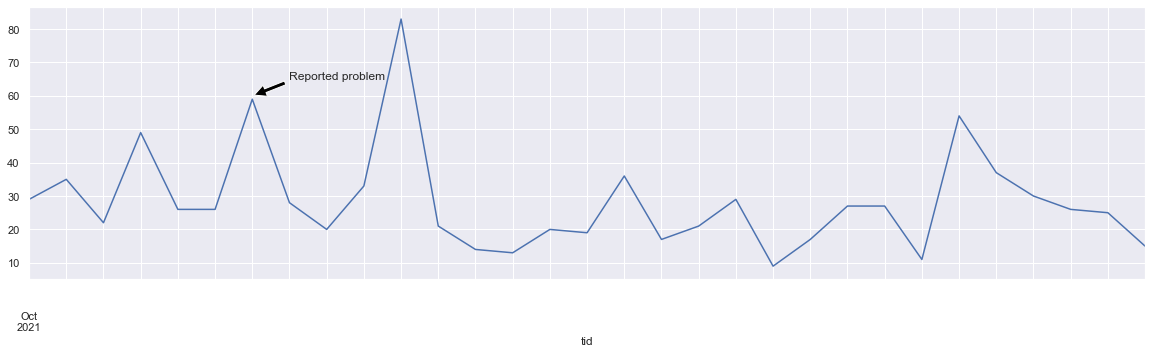

In [179]:
count_okt = oktober_østfold['hastighet_ned'].resample("D").count()
ax = count_okt.plot(figsize=(20,5))
ax.grid(True, axis="both")
ax.annotate('Reported problem', 
            xy=(np.datetime64('2021-10-07' ), 60), 
            xytext=(np.datetime64('2021-10-08'), 65), 
            arrowprops=dict(facecolor='black', shrink=0.05),)
#ax.set_xticks(pd.date_range(start='2021-10-01', end='2021-10-31', freq="D"), minor=False)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
plt.show()

DatetimeIndex(['2021-10-01', '2021-10-02', '2021-10-03', '2021-10-04',
               '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08',
               '2021-10-09', '2021-10-10', '2021-10-11', '2021-10-12',
               '2021-10-13', '2021-10-14', '2021-10-15', '2021-10-16',
               '2021-10-17', '2021-10-18', '2021-10-19', '2021-10-20',
               '2021-10-21', '2021-10-22', '2021-10-23', '2021-10-24',
               '2021-10-25', '2021-10-26', '2021-10-27', '2021-10-28',
               '2021-10-29', '2021-10-30', '2021-10-31'],
              dtype='datetime64[ns]', freq='D')